In [32]:
# Installing dependencies
#!pip install praw
#!pip install psaw
#!pip install yfinance

In [2]:
import praw
from psaw import PushshiftAPI
import json
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import traceback
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import os

# Suppress warning messages
import warnings
#warnings.filterwarnings('ignore')

In [3]:
# Load client_id, secret_id, and user_agent
with open('info.json') as f:
     info = json.load(f)
        
info = dict(info)

In [4]:
# Initialize Reddit and PushshiftAPI instances
reddit = praw.Reddit(client_id=info["client_id"], user_agent=info["user_agent"], client_secret=info["client_secret"])
api = PushshiftAPI(reddit)

In [5]:
# Store results of a search in a DataFrame
"""
subm_dicts = [{k:getattr(praw_obj, k) for k in vars(praw_obj)} for praw_obj in api.search_submissions(subreddit='stocks', q="TWTR", filter=['url','author', 'title', 'subreddit'], limit=100)]
df = pd.DataFrame(subm_dicts)
df
"""
_ = None

In [6]:
# Get historical stock data for a ticker
#twtr = yf.download('TWTR', progress=True)
#twtr

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-11-07,45.099998,50.090000,44.000000,44.900002,44.900002,117701600
2013-11-08,45.930000,46.939999,40.689999,41.650002,41.650002,27925300
2013-11-11,40.500000,43.000000,39.400002,42.900002,42.900002,16113900
2013-11-12,43.660000,43.779999,41.830002,41.900002,41.900002,6316700
2013-11-13,41.029999,42.869999,40.759998,42.599998,42.599998,8688300
...,...,...,...,...,...,...
2022-04-04,47.869999,51.369999,46.860001,49.970001,49.970001,268465400
2022-04-05,53.849998,54.570000,50.560001,50.980000,50.980000,217520100
2022-04-06,50.040001,52.869999,49.299999,50.770000,50.770000,159034700


## Processing Tickers

This initial thought process is not great. I decided that looking for specific words wwould not be a good idea, as it takes much of the context out of the comment. (Something that briefly mentions TSLA, but is actually talking about how great MSFT is would be useless in predicting TSLA stock)

In [7]:
# At close, calculate the real and percent change since last close
def get_diff(ticker_data):
    df = ticker_data.copy()
    real = []
    percent = []
    for index, row in df.reset_index().iterrows():
        if(index == 0):
            real.append(0)
            percent.append(0)
        else:
            real.append(row["Close"]-df.iloc[index-1]["Close"])
            percent.append(real[-1]/df.iloc[index-1]["Close"])
    return real, percent

# Get the reddit posts that mention a certain ticker n days before a large change in stock price
def get_pre_change_posts(ticker, ticker_gain, days=1, limit=1000, subreddit="stocks,stockmarket,stocksandtrading,daytrading,investing,stocks_picks,stockstobuytoday"):
    df = None
    for index, row in ticker_gain.iterrows():
        start_date = datetime.fromtimestamp(row["Date"].timestamp()) + timedelta(hours=6, days=-days)
        end_date = datetime.fromtimestamp(row["Date"].timestamp()) + timedelta(hours=6)
        
        # TODO: Check whether comments would be better than submissions
        
        submissions = api.search_comments(after=start_date, before=end_date, q=ticker, subreddit=subreddit, filter=['url','author', 'title', 'subreddit'], limit=limit)
        if(df is None):
            df = pd.DataFrame([{k:getattr(praw_obj, k) for k in vars(praw_obj)} for praw_obj in submissions])
        else:
            df = df.append([{k:getattr(praw_obj, k) for k in vars(praw_obj)} for praw_obj in submissions], ignore_index=True)
    return df

def word_counts(df, column="body", min_letters=3):
    counts = {}
    for i in list(df[column]):
        for j in i.split(" "):
            j = ''.join(k for k in j if k.isalnum())
            # Exclude words that are likely tickers
            if(j == j.upper() and len(j) > 1 and len(j) <= 5):
                pass
            elif(len(j) < 3):
                pass
            elif(j not in counts.keys()):
                counts[j.lower()] = 1
            else:
                counts.update({j.lower():counts.get(j.lower())+1})
    return counts

def remove_shared_keys(dict_a, dict_b, cutoff=2):
    a = dict_a.copy()
    b = dict_b.copy()
    
    rm_a = []
    rm_b = []
    for i in a:
        if(i in b):
            if(b.get(i) > 2*a.get(i)):
                rm_a.append(i)
            elif(b.get(i) < 2*a.get(i)):
                rm_b.append(i)
            else:
                rm_a.append(i)
                rm_b.append(i)
    for i in rm_a:
        a.pop(i)
    for i in rm_b:
        b.pop(i)
    return a, b

def remove_infrequent_words(dict_a, min_count=2):
    d = dict_a.copy()
    
    to_remove = []
    for i, x in d.items():
        if(x < min_count):
            to_remove.append(i)
            
    for i in to_remove:
        d.pop(i)
        
    return d

# Generate information for a given ticker
def process_ticker(ticker, gain_cutoff=0.05, loss_cutoff=0.05, limit=100, days=1):
    try:
        ticker_data = yf.download(ticker, progress=False)
        ticker_data.reset_index(inplace=True)
        real, percent = get_diff(ticker_data)

        ticker_data["Real_Change"] = real
        ticker_data["Percent_Change"] = percent

        ticker_gain = ticker_data[ticker_data["Percent_Change"] > gain_cutoff]
        ticker_loss = ticker_data[ticker_data["Percent_Change"] < -loss_cutoff]

        pre_gain = get_pre_change_posts(ticker, ticker_gain, days, limit)
        pre_loss = get_pre_change_posts(ticker, ticker_loss, days, limit)

        gain_wc = dict(sorted(word_counts(pre_gain).items(), key=lambda x: x[1], reverse=True))
        loss_wc = dict(sorted(word_counts(pre_loss).items(), key=lambda x: x[1], reverse=True))

        gain_freq = remove_infrequent_words(gain_wc)
        loss_freq = remove_infrequent_words(loss_wc)

        gain_only, loss_only = remove_shared_keys(gain_freq, loss_freq)
    except Exception as e:
        print(e)
        return {}, {}
    
    return gain_only, loss_only

#gain_only, loss_only = process_ticker("FB")

#gain_only

#loss_only
"""
all_gain = []
all_loss = []
for ticker in ["TWTR", "FB", "MSFT", "ADBE", "AAPL", "SNAP", "AMZN", "NCL", "DIS", "NFLX"]:
    gain_only, loss_only = process_ticker(ticker)
    all_gain.append(gain_only)
    all_loss.append(loss_only)
    print(ticker)

def combine_dict_list(list_of_dicts):
    single_dict = {}
    for d in list_of_dicts:
        for i in d:
            if(i not in single_dict):
                single_dict[i] = d.get(i)
            else:
                single_dict.update({i:single_dict.get(i)+d.get(i)})
    return dict(sorted(single_dict.items(), key=lambda x: x[1], reverse=True))

gain, loss = remove_shared_keys(combine_dict_list(all_gain), combine_dict_list(all_loss))

gain

loss"""
_ = None # This is just to stop automatic output of block commented code

## Better Method (Probably)

Instead of looking at posts/comments the day before and predicting whether the next day will close higher, this will be looking at the posts/comments from the previous day's close to the current day's open and predicting whether the close price will be higher than the open price. 

In [8]:
def daily_change(data):
    change = []
    up = []
    for index, row in data.iterrows():
        change.append(row["Close"]-row["Open"])
        up.append(int(change[-1] > 0))
    return change, up

In [9]:
#change, up = daily_change(twtr)

In [10]:
#twtr["Daily_Change"] = change
#twtr["Positive_Change"] = up

In [11]:
#twtr = twtr.sample(frac=1)

In [12]:
#twtr

,Open,High,Low,Close,Adj Close,Volume,Daily_Change,Positive_Change
Date,,,,,,,,
2019-02-06,35.049999,35.250000,33.750000,34.160000,34.160000,34058000,-0.889999,0
2016-04-27,15.150000,15.280000,14.810000,14.860000,14.860000,84880300,-0.290000,0
2020-10-22,50.000000,50.340000,48.110001,50.279999,50.279999,18289000,0.279999,1
2021-04-12,70.870003,71.839996,69.650002,70.860001,70.860001,9495200,-0.010002,0
2014-06-02,32.889999,33.200001,31.620001,31.750000,31.750000,31209800,-1.139999,0
...,...,...,...,...,...,...,...,...
2014-10-30,41.560001,42.480000,39.939999,41.799999,41.799999,42012600,0.239998,1
2019-03-01,31.170000,31.190001,30.280001,30.620001,30.620001,12360700,-0.549999,0
2020-12-22,55.000000,55.680000,54.369999,54.910000,54.910000,9259200,-0.090000,0


In [13]:
def get_pre_open_content(data, ticker, start_hour_diff=0, subreddit="stocks,stockmarket,stocksandtrading,daytrading,investing,stocks_picks,stockstobuytoday", limit=100):
    new_col = []
    for index, row in data.iterrows():
        end_time = row.name + timedelta(hours=9, minutes=30)
        start_time = end_time - timedelta(hours=17, minutes=30)
        content = []
        for i in api.search_comments(after=start_time, before=end_time, subreddit=subreddit, q=ticker, filter=['url','author', 'title', 'subreddit'], limit=limit):
            for j in i.body.split("."):
                for k in j.split("\n"):
                    content.append(k)
        new_col.append(content)
    
    return new_col

In [15]:
# This takes quite a while to run. Looking into how to speed it up. 
#twtr_full = twtr.copy()
#twtr = twtr.head(10)
#twtr["Comments"] = get_pre_open_content(twtr, "TWTR", limit=100)

In [16]:
#twtr

,Open,High,Low,Close,Adj Close,Volume,Daily_Change,Positive_Change,Comments
Date,,,,,,,,,
2019-02-06,35.049999,35.250000,33.750000,34.160000,34.160000,34058000,-0.889999,0,[]
2016-04-27,15.150000,15.280000,14.810000,14.860000,14.860000,84880300,-0.290000,0,"[Some people say TWTR is done for, , , Others ..."
2020-10-22,50.000000,50.340000,48.110001,50.279999,50.279999,18289000,0.279999,1,"[FB, TWTR & MTCH are saving my portfolio all ..."
2021-04-12,70.870003,71.839996,69.650002,70.860001,70.860001,9495200,-0.010002,0,[]
2014-06-02,32.889999,33.200001,31.620001,31.750000,31.750000,31209800,-1.139999,0,[]
...,...,...,...,...,...,...,...,...,...
2014-10-30,41.560001,42.480000,39.939999,41.799999,41.799999,42012600,0.239998,1,[I typically do weekly options on volatile sto...
2019-03-01,31.170000,31.190001,30.280001,30.620001,30.620001,12360700,-0.549999,0,[]
2020-12-22,55.000000,55.680000,54.369999,54.910000,54.910000,9259200,-0.090000,0,[]


### Preparing text for analysis

In [18]:
def split_sequences(data):
    dates = []
    seqs = []
    vals = []
    
    for index, row in data.iterrows():
        for comment in row["Comment_Sequences"]:
            if(comment != []):
                dates.append(row.name)
                seqs.append(list(comment))
                vals.append(row["Positive_Change"])
    return pd.DataFrame({"Date":dates, "Sequence":seqs, "Positive_Change":vals})

In [125]:
def prepare_text(data, train_proportion = 0.8, max_len=50, tokenizer=None):
    if(tokenizer is None):
        tokenizer = Tokenizer(oov_token = "<OOV>")
    
    train = data[:int(data.shape[0]*train_proportion)]
    test = data[int(data.shape[0]*train_proportion):]
    
    for comment in train.Comments:
        tokenizer.fit_on_texts(comment)
        
    seqs = []
    for comment in train.Comments:
        seqs.append(tokenizer.texts_to_sequences(comment))
    
    train["Comment_Sequences"] = seqs
    
    train = split_sequences(train)
        
    train_padded = pad_sequences(train["Sequence"], padding="post", truncating="post", maxlen=max_len)

    for comment in test.Comments:
        tokenizer.fit_on_texts(comment)
        
    seqs = []
    for comment in test.Comments:
        seqs.append(tokenizer.texts_to_sequences(comment))
    
    test["Comment_Sequences"] = seqs
    
    test = split_sequences(test)
        
    test_padded = pad_sequences(test["Sequence"], padding="post", truncating="post", maxlen=max_len)
    
    return train, train_padded, test, test_padded, tokenizer

In [151]:
def generate_ticker_data(tickers = None):
    if(tickers is None): return None
    
    cur_tokenizer = None
    
    for ticker in tickers:
        if(f"{ticker}.pkl" in os.listdir('data/')):
            continue
        
        data = yf.download(ticker)
        change, up = daily_change(data)
        data["Daily_Change"] = change
        data["Positive_Change"] = up
        data = data.sample(frac=1)
        
        data["Comments"] = get_pre_open_content(data, ticker, limit=100)
        
        train, train_padded, test, test_padded, cur_tokenizer = prepare_text(data, tokenizer=cur_tokenizer)
        
        with open(f"data/{ticker}.pkl", "wb+") as f:
            pickle.dump((train, train_padded, test, test_padded), f)
            
        used_tickers = "_".join(tickers[:tickers.index(ticker)+1])
        
        with open(f"data/tokenizer/tokenizer_{used_tickers}.pkl", "wb+") as f:
            pickle.dump(tokenizer, f)

In [152]:
generate_ticker_data(["TWTR"])

[*********************100%***********************]  1 of 1 completed


C:\Users\zdude\Anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
C:\Users\zdude\Anaconda3\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\Users\zdude\Anaconda3\lib\site-packages\psaw\PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")
C:\Users\zdude\AppData\Local\Temp\ipykernel_10588\3286485899.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Comment_Sequences"] = seqs
C:\Users\zdude\AppData\Local\Temp\ip

In [155]:
#with open("data/TWTR.pkl", "rb") as f:
#    train, train_padded, test, test_padded = pickle.load(f)

In [157]:
#train_padded

array([[  7,   0,   0, ...,   0,   0,   0],
       [  7,   0,   0, ...,   0,   0,   0],
       [194,  51,  23, ...,   0,   0,   0],
       ...,
       [  6,  60,  28, ...,   0,   0,   0],
       [104, 463,  14, ...,   0,   0,   0],
       [220,  44,  97, ...,   0,   0,   0]])

### Creating TensorFlow Network

In [109]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(len(tokenizer.word_index)+1, 16, input_length=max_len))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(24, activation='relu'))
model.add(tf.keras.layers.Dense(48, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [110]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 16)           136528    
                                                                 
 global_average_pooling1d_5   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_15 (Dense)            (None, 24)                408       
                                                                 
 dense_16 (Dense)            (None, 48)                1200      
                                                                 
 dense_17 (Dense)            (None, 1)                 49        
                                                                 
Total params: 138,185
Trainable params: 138,185
Non-trainable params: 0
________________________________________________

In [111]:
model.fit(train_padded, train["Positive_Change"], epochs=30, validation_data=(test_padded, test["Positive_Change"]), verbose=2)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosit

In [112]:
pred = model.predict(test_padded)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [113]:
real_pred = []
for i in pred:
    real_pred.append(1 if i > 0.5 else 0)

In [114]:
from sklearn.metrics import accuracy_score

In [115]:
accuracy_score(real_pred, test["Positive_Change"])

0.4989827060020346

### Evaluating Model

In [116]:
def evaluate(test_data, padded, model):
    days = []
    correct_proportion = []
    pred_sum = []
    
    for date in test_data.Date.unique():
        days.append(date)
        
        day = test_data[test_data["Date"] == date]
                
        day_padded = padded[day.index[0]:day.index[-1]+1]
        
        pred = model.predict(day_padded)
        
        real_pred = []
        for i in pred:
            real_pred.append(1 if i > 0.5 else 0)
            
        exp = list(day["Positive_Change"])[0]
        pred_sum.append(sum(real_pred))
        correct_count = 0
        for i in real_pred:
            if(i == exp):
                correct_count += 1
        correct_proportion.append(correct_count/len(real_pred))
    return pd.DataFrame({"Date":days, "Correct_Proportion":correct_proportion, "Prediction_Sum":pred_sum})

In [117]:
results = evaluate(test, test_padded, model)
results

,Date,Correct_Proportion,Prediction_Sum
0,2016-05-12,0.285714,5
1,2014-03-13,0.250000,3
2,2019-01-08,0.500000,1
3,2022-03-28,1.000000,3
4,2015-04-27,0.500000,2
...,...,...,...
162,2015-07-10,0.538462,7
163,2015-04-29,0.426230,35
164,2018-08-29,0.500000,2
165,2018-01-05,0.555556,5


<AxesSubplot:>

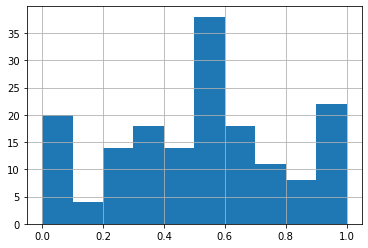

In [118]:
results.Correct_Proportion.hist()